In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def random_uniform_disk(n, radius=1.0):
    theta = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    r = np.sqrt(np.random.uniform(low=0.0, high=radius**2, size=n))
    x, y = r * np.cos(theta), r * np.sin(theta)
    return np.column_stack((x, y))

def random_uniform_ellipse(n, M=np.eye(2)):
    return random_uniform_disk(n) @ M

In [142]:
N = 50000
M = np.array([[0.9, -0.2], [-0.2, 0.9]])
p = random_uniform_ellipse(N, M=M)

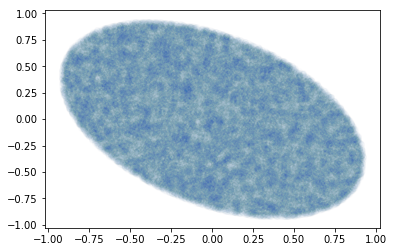

In [167]:
plt.scatter(p[:, 0], p[:, 1], alpha=0.01)

In [144]:
sources = random_uniform_ellipse(N, M=M)
targets = random_uniform_ellipse(N, M=M)

In [165]:
def sample_gamma(n, mode=1.0, shape=5.0):
    scale = mode / (shape - 1)
    return np.random.gamma(shape=shape, scale=scale, size=n)

In [217]:
def compute_commute_time(sources, targets):
    assert sources.shape == targets.shape
    assert sources.shape[1] == 2
    N = sources.shape[0]
    raw_time = compute_raw_time(sources, targets)
    # Scale is chosen so that the mode of the conjestion_factor is one.
    conjestion_factor = np.maximum(
        sample_gamma(n=N, mode=1.0, shape=5.0), 1.0)
    geometry_factor = compute_geometry_factor(sources, targets)
    return geometry_factor * conjestion_factor * raw_time

def compute_raw_time(sources, targets):
    raw_time = (
        np.abs(sources[:, 0] - targets[:, 0]) +
        np.abs(sources[:, 1] - targets[:, 1]))
    return raw_time

def compute_geometry_factor(sources, targets):
    N = sources.shape[0]
    first_to_fourth_quad_factor = np.maximum(
        sample_gamma(n=N, mode=5.0, shape=10.0), 1.0)
    first_or_fourth_to_bottom_half_factor = np.maximum(
        sample_gamma(n=N, mode=2.0, shape=5.0), 1.0)
    cond_list = [
        in_first_quad(sources) & in_fourth_quad(targets),
        in_fourth_quad(sources) & in_first_quad(targets),
        (in_first_quad(sources) | in_fourth_quad(sources)) 
            & in_lower_half_plane(targets),
        (in_first_quad(targets) | in_fourth_quad(targets)) 
            & in_lower_half_plane(sources),
    ]
    choice_list = [
        first_to_fourth_quad_factor,
        first_to_fourth_quad_factor,
        first_or_fourth_to_bottom_half_factor,
        first_or_fourth_to_bottom_half_factor
    ]
    return np.maximum(
        np.select(cond_list, choice_list, default=1.0), 1.0)
                                      
def in_first_quad(xy):
    return (xy[:, 0] >= 0) & (xy[:, 1] >= 0)

def in_fourth_quad(xy):
    return (xy[:, 0] <= 0) & (xy[:, 1] >= 0)

def in_lower_half_plane(xy):
    return xy[:, 1] <= 0

In [218]:
rt = compute_raw_time(sources, targets)

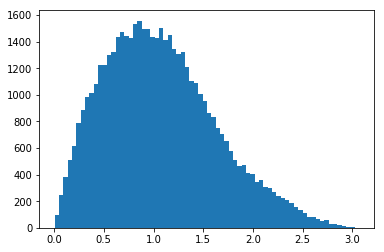

In [219]:
_ = plt.hist(rt, bins=70)

In [220]:
ct = compute_commute_time(sources, targets)

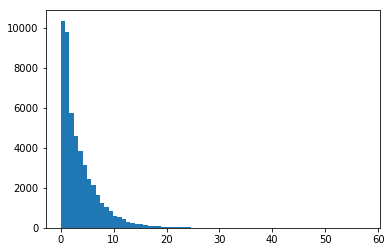

In [221]:
_ = plt.hist(ct, bins=70)

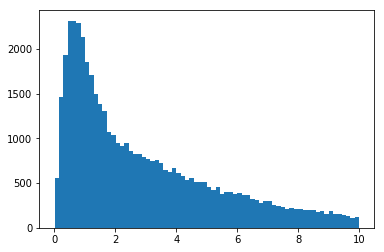

In [222]:
_ = plt.hist(ct[ct < 10], bins=70)

In [223]:
gf = compute_geometry_factor(sources, targets)

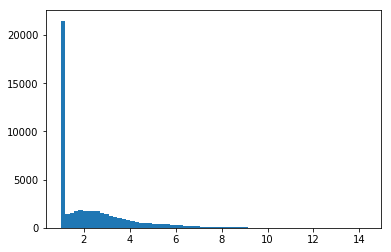

In [224]:
_ = plt.hist(gf, bins=70)

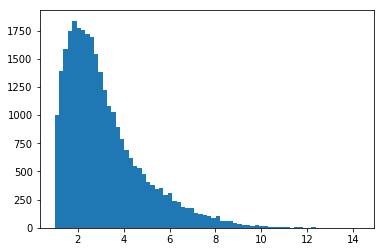

In [225]:
_ = plt.hist(gf[gf > 1.0], bins=70)